<a href="https://colab.research.google.com/github/obaileyw-uncc/ecgr5105/blob/main/hw07_cnns/hw07_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECGR 5105 Homework 7: Convolutional Neural Networks
**Owen Bailey-Waltz (801488178)**

In [ ]:
# import required packages, load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn import datasets, metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from IPython.display import display

In [ ]:
# loss convergence plot from HW2
def plot_convergence(train_loss_history, val_loss_history):
  print("Training loss history: {}".format(train_loss_history))
  print("Validation loss history: {}".format(val_loss_history))

  # plot the loss over time
  plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, color='blue')
  plt.plot(range(1, len(train_loss_history) + 1), val_loss_history, color='orange')
  plt.grid(True)
  plt.legend(['Training', 'Validation'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss (J)')
  plt.title('Convergence of gradient descent (X)')
  plt.show()

## Problem 1: CIFAR10 Image Classification

### (a) Example neural network expanded to 10 features

In [ ]:
# import dataset
from torchvision import datasets as tvd
from torchvision import transforms
data_path = '../data-unversioned/p1ch7'
cifar10 = tvd.CIFAR10(data_path, train=True, download=True,
                      transform=transforms.ToTensor())
cifar10_val = tvd.CIFAR10(data_path, train=False, download=True,
                          transform=transforms.ToTensor())

100%|██████████| 170M/170M [00:16<00:00, 10.3MB/s]


In [ ]:
# stack tensor in memory (see text)
imgs = torch.stack([img for img, _ in cifar10], dim=3)
imgs_val = torch.stack([img for img, _ in cifar10_val], dim=3)
imgs.shape, imgs_val.shape

(torch.Size([3, 32, 32, 50000]), torch.Size([3, 32, 32, 10000]))

In [ ]:
mu = imgs.view(3, -1).mean(dim=1)
sigma = imgs.view(3, -1).std(dim=1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mu, std=sigma)
])
cifar10 = tvd.CIFAR10(data_path, train=True, download=False,
                      transform=transform)
cifar10_val = tvd.CIFAR10(data_path, train=False, download=False,
                          transform=transform)

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f'Now training on device {device}')

Now training on device cuda


In [ ]:
# model class declaration
class CNN1a(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * 8, 64)
    self.act3 = nn.Tanh()
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = out.view(-1, 8 * 8 * 8)
    out = self.act3(self.fc1(out))
    out = self.fc2(out)
    return out

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
          'horse', 'ship', 'truck'] # labels map 1:1 to CIFAR10
n_out = 10
model = CNN1a().to(device=device)

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                           shuffle=False)

alpha = 1e-2
optimizer = optim.SGD(model.parameters(), lr=alpha)
n_epochs = 300
loss_fn = nn.CrossEntropyLoss()

loss_train_history = np.zeros(n_epochs)
loss_val_history = np.zeros(n_epochs)
for epoch in range(1, n_epochs + 1):
  for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    batch_size = imgs.shape[0]
    h_train = model.forward(imgs)
    loss_train = loss_fn(h_train, labels)
    loss_train_history[epoch-1] = loss_train

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

  total = 0
  correct = 0
  with torch.no_grad():
    for imgs, labels in val_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      batch_size = imgs.shape[0]
      h_val = model.forward(imgs)
      loss_val = loss_fn(h_val, labels)
      loss_val_history[epoch-1] = loss_val

      _, labels_val = torch.max(h_val, dim=1)

      confusion = metrics.confusion_matrix(labels.cpu(), labels_val.cpu())
      total += labels.shape[0]
      correct += int((labels == labels_val).sum())
      training_metrics = {'Accuracy': (correct / total),
                          'Precision': metrics.precision_score(labels.cpu(),
                                                               labels_val.cpu(),
                                                               average='macro',
                                                               zero_division=0),
                          'Recall': metrics.recall_score(labels.cpu(),
                                                         labels_val.cpu(),
                                                         average='macro',
                                                         zero_division=0),
                          'F1 Score': metrics.f1_score(labels.cpu(),
                                                       labels_val.cpu(),
                                                       average='macro',
                                                       zero_division=0)}

  print(f'Epoch {epoch}: training loss {loss_train:.4f},',
        f'validation loss {loss_val:.4f}')
  for i in training_metrics:
    print("{}: {}".format(i, training_metrics[i]))
  print()

Epoch 1: training loss 1.9571, validation loss 1.6425
Accuracy: 0.3747
Precision: 0.17592592592592593
Recall: 0.14814814814814814
F1 Score: 0.15767195767195769

Epoch 2: training loss 1.7139, validation loss 1.5716
Accuracy: 0.4311
Precision: 0.1833333333333333
Recall: 0.16666666666666666
F1 Score: 0.17333333333333334

Epoch 3: training loss 1.5256, validation loss 1.4347
Accuracy: 0.47
Precision: 0.175
Recall: 0.16666666666666666
F1 Score: 0.16857142857142854

Epoch 4: training loss 0.9264, validation loss 1.3141
Accuracy: 0.5
Precision: 0.2777777777777778
Recall: 0.2962962962962963
F1 Score: 0.2740740740740741

Epoch 5: training loss 1.6418, validation loss 1.1496
Accuracy: 0.5159
Precision: 0.53125
Recall: 0.4375
F1 Score: 0.46904761904761905

Epoch 6: training loss 1.0855, validation loss 1.0265
Accuracy: 0.5224
Precision: 0.5092592592592593
Recall: 0.4259259259259259
F1 Score: 0.45079365079365075

Epoch 7: training loss 1.0459, validation loss 1.1218
Accuracy: 0.5486
Precision: 0.

Training loss history: [1.95708299 1.71388149 1.5256021  0.92637336 1.64183807 1.08545971
 1.04588509 1.47567093 1.41133344 1.25836802 0.6790393  1.48414445
 1.67698812 1.2452966  1.19335198 1.43770373 1.26930475 0.93484652
 0.68326557 0.96407062 1.19170618 1.01674068 0.84726691 0.6473763
 0.79427689 0.97944599 0.79001278 0.92437547 0.81924391 0.81997895
 0.67623264 1.40533853 1.08371806 1.13706267 0.78264654 0.93843567
 1.21333885 0.80528516 0.74231702 0.61994642 0.8387025  0.70439458
 1.07073271 1.00538826 0.59638262 1.06898713 0.99192762 1.2146951
 0.72086287 0.66490173 0.67133337 0.82889366 0.5848822  0.61431122
 0.93060768 1.01246953 0.84302646 0.87360519 0.55365431 0.75167918
 0.52385044 0.24220973 0.52688795 0.6167028  0.97219729 0.5506469
 0.71701533 0.5700438  0.40442407 0.9805488  0.37529826 0.88498783
 0.64159381 0.68972123 0.59351116 1.04481614 0.78143346 0.63624936
 0.4718765  0.91796964 0.69743842 0.50839305 0.54560208 0.49794477
 0.29918084 0.64557302 0.47446632 0.794607

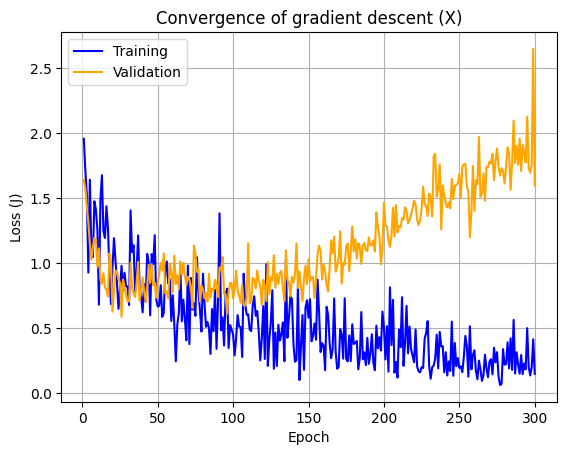

Text(50.722222222222214, 0.5, 'Actual')

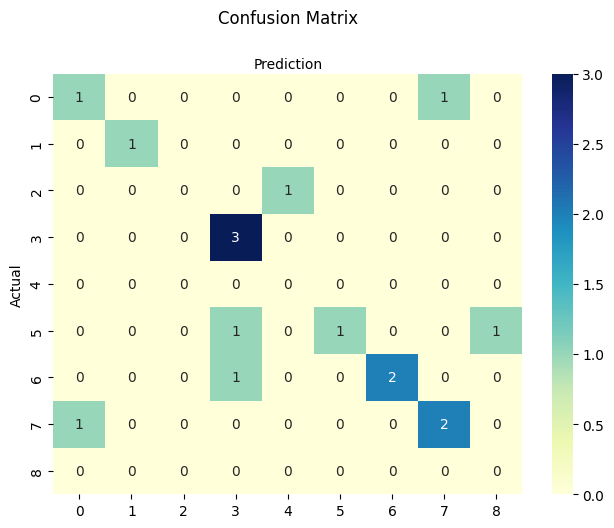

In [ ]:
# plot the convergence per epoch
plot_convergence(loss_train_history, loss_val_history)

# create heatmap for confusion matrix
# code frome example
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

The shallow CNN classifier discussed in class extended to ten classes provides a much better fit than the fully-connected neural network. The network still overfits after roughly fifty epochs, but the maximum accuracy is over 50% and occasionally nears 60% depending on the point in training. The minimum validation loss of 0.7332, indicating maximum generalization, occurs at epoch 49.

### (b) Deeper CNN classifier

In [ ]:
# model class declaration
class CNN1b(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
    self.act1 = nn.Tanh()
    self.pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
    self.act2 = nn.Tanh()
    self.pool2 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
    self.act3 = nn.Tanh()
    self.pool3 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(4 * 4 * 8, 64)
    self.act4 = nn.Tanh()
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.pool2(self.act2(self.conv2(out)))
    out = self.pool3(self.act3(self.conv3(out)))
    out = out.view(-1, 4 * 4 * 8)
    out = self.act4(self.fc1(out))
    out = self.fc2(out)
    return out

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
          'horse', 'ship', 'truck'] # labels map 1:1 to CIFAR10
n_out = 10
model = CNN1b().to(device=device)

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                           shuffle=False)

alpha = 1e-2
optimizer = optim.SGD(model.parameters(), lr=alpha)
n_epochs = 300
loss_fn = nn.CrossEntropyLoss()

loss_train_history = np.zeros(n_epochs)
loss_val_history = np.zeros(n_epochs)
for epoch in range(1, n_epochs + 1):
  for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    batch_size = imgs.shape[0]
    h_train = model.forward(imgs)
    loss_train = loss_fn(h_train, labels)
    loss_train_history[epoch-1] = loss_train

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

  total = 0
  correct = 0
  with torch.no_grad():
    for imgs, labels in val_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      batch_size = imgs.shape[0]
      h_val = model.forward(imgs)
      loss_val = loss_fn(h_val, labels)
      loss_val_history[epoch-1] = loss_val

      _, labels_val = torch.max(h_val, dim=1)

      confusion = metrics.confusion_matrix(labels.cpu(), labels_val.cpu())
      total += labels.shape[0]
      correct += int((labels == labels_val).sum())
      training_metrics = {'Accuracy': (correct / total),
                          'Precision': metrics.precision_score(labels.cpu(),
                                                               labels_val.cpu(),
                                                               average='macro',
                                                               zero_division=0),
                          'Recall': metrics.recall_score(labels.cpu(),
                                                         labels_val.cpu(),
                                                         average='macro',
                                                         zero_division=0),
                          'F1 Score': metrics.f1_score(labels.cpu(),
                                                       labels_val.cpu(),
                                                       average='macro',
                                                       zero_division=0)}

  print(f'Epoch {epoch}: training loss {loss_train:.4f},',
        f'validation loss {loss_val:.4f}')
  for i in training_metrics:
    print("{}: {}".format(i, training_metrics[i]))
  print()

/tmp/ipython-input-902441802.py:25: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  loss_train_history[epoch-1] = loss_train


Epoch 1: training loss 2.0538, validation loss 1.7693
Accuracy: 0.3121
Precision: 0.13333333333333333
Recall: 0.06666666666666667
F1 Score: 0.08333333333333333

Epoch 2: training loss 1.7642, validation loss 1.6944
Accuracy: 0.364
Precision: 0.16666666666666666
Recall: 0.14814814814814814
F1 Score: 0.1523809523809524

Epoch 3: training loss 1.9017, validation loss 1.5468
Accuracy: 0.377
Precision: 0.19166666666666665
Recall: 0.2
F1 Score: 0.19238095238095237

Epoch 4: training loss 1.9662, validation loss 1.5664
Accuracy: 0.4157
Precision: 0.13666666666666666
Recall: 0.16666666666666666
F1 Score: 0.1488095238095238

Epoch 5: training loss 1.2602, validation loss 1.4795
Accuracy: 0.4461
Precision: 0.3333333333333333
Recall: 0.2962962962962963
F1 Score: 0.30793650793650795

Epoch 6: training loss 1.4902, validation loss 1.4504
Accuracy: 0.4417
Precision: 0.25
Recall: 0.19999999999999998
F1 Score: 0.19666666666666668

Epoch 7: training loss 1.3277, validation loss 1.3746
Accuracy: 0.4734


Training loss history: [2.05378318 1.76420426 1.90172648 1.96616983 1.26022601 1.49016333
 1.32774019 1.50346756 1.38761806 1.09344172 1.28325784 1.21890998
 1.16305304 1.45693278 1.54046285 1.11633182 0.65181434 1.10651827
 0.67895198 0.77277553 1.11226189 1.17059922 0.98763716 1.36970735
 0.75998962 1.11205149 1.09138727 1.22446716 1.00083578 0.89051491
 1.04518127 1.0811131  0.77980304 1.25559914 0.81713939 0.95423901
 0.95551127 0.91323465 0.77838182 0.9108839  0.90866327 0.79978442
 1.05237305 0.7880528  0.76858628 1.21861982 1.26561701 1.60780764
 0.51610255 0.58900905 1.18177843 0.63232434 0.88185465 0.98825169
 1.11682737 0.90369332 0.59090447 0.86208421 0.67546582 0.90340066
 0.96412003 0.88164955 1.13745856 1.11626136 0.69687998 1.14169645
 0.88572884 0.66004938 1.62529874 0.46713889 0.50975823 1.08754778
 0.78267443 0.63380396 0.58170849 0.88862276 1.40668726 0.96085244
 1.31677163 0.40481216 0.93491673 1.33116269 0.85495573 1.38464308
 1.04115999 0.83614707 0.63689053 0.605

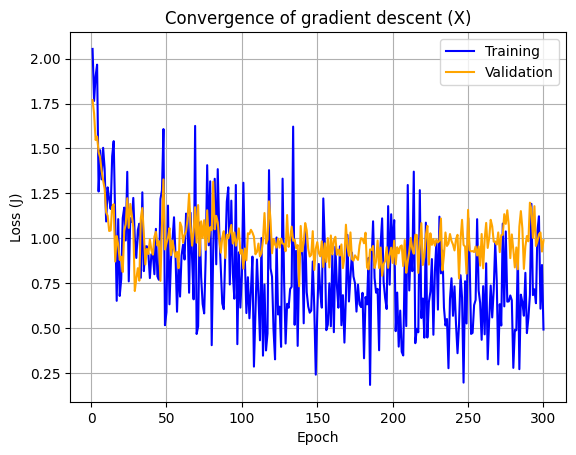

Text(50.722222222222214, 0.5, 'Actual')

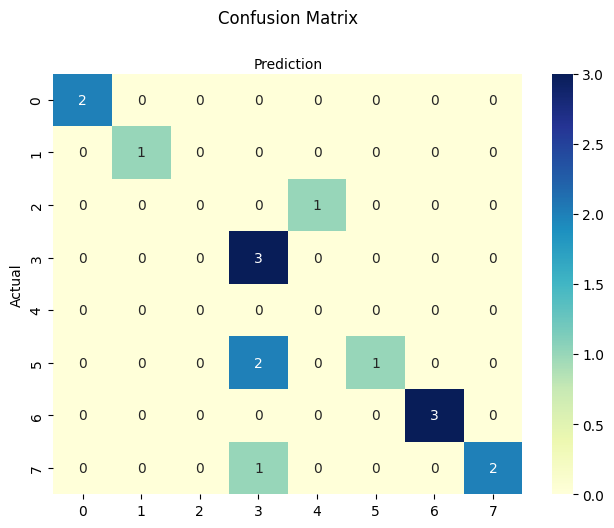

In [ ]:
# plot the convergence per epoch
plot_convergence(loss_train_history, loss_val_history)

# create heatmap for confusion matrix
# code frome example
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

Adding an additional convolutional layer to the network reduces overfitting greatly. The network likely still requires a degree of precision that it has not yet attained to become more accurate as a classifier, but observing the training convergence reveals that, while the training process is much noisier and there are larger fluctuations in instantaneous loss than with the less complex network, the model does not overfit as much and validation loss remains constant around 1.0 rather than diverging as gradient descent fits closer with the training data. The ending F1 score after 300 epochs is 62.1%, which is approximately equal to the performance 124 epochs prior at Epoch 176, and the classifier's validation accuracy after training converges to values near 70%. All of these metrics show profound improvements compared to the shallower CNN classifier and the classifier which only uses a fully-connected neural network.

## Problem 2: ResNet-10

### (a) Basic ResNet-10

In [ ]:
# basic ResNet from lecture/DLWPT
class ResBlockBasic(nn.Module):
  def __init__(self, n_chans=2):
    super(ResBlockBasic, self).__init__()
    self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                          padding=1, bias=False)

  def forward(self, x):
    out = self.conv(x)
    out = torch.relu(out)
    return out + x

In [ ]:
# model class declaration
class ResNet10(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)
    self.resblocks = nn.Sequential(
        *(10 * [ResBlockBasic(n_chans=n_chans1)])
    )
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * n_chans1, 64)
    self.act2 = nn.Tanh()
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.resblocks(out)
    out = self.pool2(out)
    out = out.view(-1, 8 * 8 * self.n_chans1)
    out = self.act2(self.fc1(out))
    out = self.fc2(out)
    return out

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
          'horse', 'ship', 'truck'] # labels map 1:1 to CIFAR10
n_out = 10
model = ResNet10().to(device=device)

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                           shuffle=False)

alpha = 1e-2
optimizer = optim.SGD(model.parameters(), lr=alpha)
n_epochs = 300
loss_fn = nn.CrossEntropyLoss()

loss_train_history = np.zeros(n_epochs)
loss_val_history = np.zeros(n_epochs)
for epoch in range(1, n_epochs + 1):
  for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    batch_size = imgs.shape[0]
    h_train = model.forward(imgs)
    loss_train = loss_fn(h_train, labels)
    loss_train_history[epoch-1] = loss_train

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

  total = 0
  correct = 0
  with torch.no_grad():
    for imgs, labels in val_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      batch_size = imgs.shape[0]
      h_val = model.forward(imgs)
      loss_val = loss_fn(h_val, labels)
      loss_val_history[epoch-1] = loss_val

      _, labels_val = torch.max(h_val, dim=1)

      confusion = metrics.confusion_matrix(labels.cpu(), labels_val.cpu())
      total += labels.shape[0]
      correct += int((labels == labels_val).sum())
      training_metrics = {'Accuracy': (correct / total),
                          'Precision': metrics.precision_score(labels.cpu(),
                                                               labels_val.cpu(),
                                                               average='macro',
                                                               zero_division=0),
                          'Recall': metrics.recall_score(labels.cpu(),
                                                         labels_val.cpu(),
                                                         average='macro',
                                                         zero_division=0),
                          'F1 Score': metrics.f1_score(labels.cpu(),
                                                       labels_val.cpu(),
                                                       average='macro',
                                                       zero_division=0)}

  print(f'Epoch {epoch}: training loss {loss_train:.4f},',
        f'validation loss {loss_val:.4f}')
  for i in training_metrics:
    print("{}: {}".format(i, training_metrics[i]))
  print()

Epoch 1: training loss 1.4747, validation loss 1.3371
Accuracy: 0.4182
Precision: 0.4166666666666667
Recall: 0.4444444444444444
F1 Score: 0.41375661375661377

Epoch 2: training loss 1.3417, validation loss 1.4956
Accuracy: 0.4615
Precision: 0.325
Recall: 0.3
F1 Score: 0.2823809523809524

Epoch 3: training loss 1.0115, validation loss 1.3971
Accuracy: 0.5362
Precision: 0.25925925925925924
Recall: 0.2962962962962963
F1 Score: 0.2322751322751323

Epoch 4: training loss 0.9150, validation loss 0.9130
Accuracy: 0.5845
Precision: 0.6574074074074073
Recall: 0.574074074074074
F1 Score: 0.5989417989417989

Epoch 5: training loss 0.9513, validation loss 0.9711
Accuracy: 0.5514
Precision: 0.4722222222222222
Recall: 0.4444444444444444
F1 Score: 0.45079365079365075

Epoch 6: training loss 1.0413, validation loss 0.8793
Accuracy: 0.5649
Precision: 0.619047619047619
Recall: 0.6428571428571429
F1 Score: 0.6285714285714284

Epoch 7: training loss 0.5822, validation loss 1.0783
Accuracy: 0.6562
Precisio

Training loss history: [1.47468865e+00 1.34171116e+00 1.01148820e+00 9.14967895e-01
 9.51313138e-01 1.04131830e+00 5.82239628e-01 5.10057330e-01
 6.82261467e-01 8.28250587e-01 5.44006109e-01 1.00236332e+00
 9.06992733e-01 6.19828701e-01 9.71315384e-01 5.72086394e-01
 9.49272931e-01 4.78350371e-01 2.86847293e-01 3.30104500e-01
 2.84116209e-01 2.41001338e-01 2.46828750e-01 3.39608371e-01
 5.04644036e-01 4.79327738e-01 7.05741942e-02 5.23384809e-01
 7.70234540e-02 4.10834670e-01 2.09855467e-01 1.87629163e-01
 3.21753234e-01 4.13869679e-01 3.17424417e-01 1.26223207e-01
 1.32562056e-01 2.40359724e-01 3.15085612e-02 1.16661459e-01
 1.43483490e-01 4.04340141e-02 1.04571126e-01 3.58392671e-02
 6.02030642e-02 7.21896067e-02 3.58112827e-02 4.21303287e-02
 1.99462771e-02 1.19795054e-02 2.69572902e-02 1.97642148e-02
 5.37524465e-03 1.12777203e-02 4.49550226e-02 1.05719566e-02
 1.02069527e-02 1.46947373e-02 3.28696407e-02 1.53801916e-02
 8.31658952e-03 9.25319921e-03 9.66940448e-03 1.08262580e-02
 

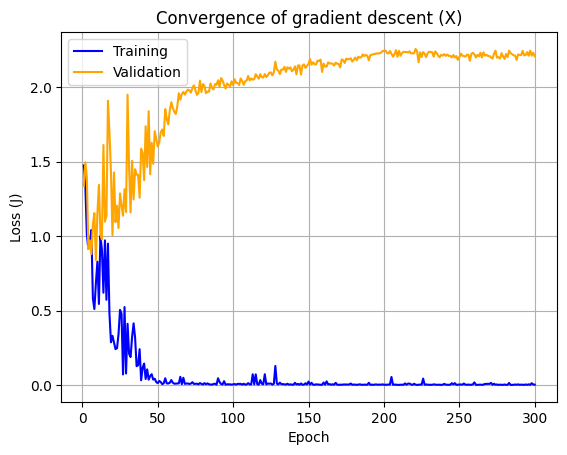

Text(50.722222222222214, 0.5, 'Actual')

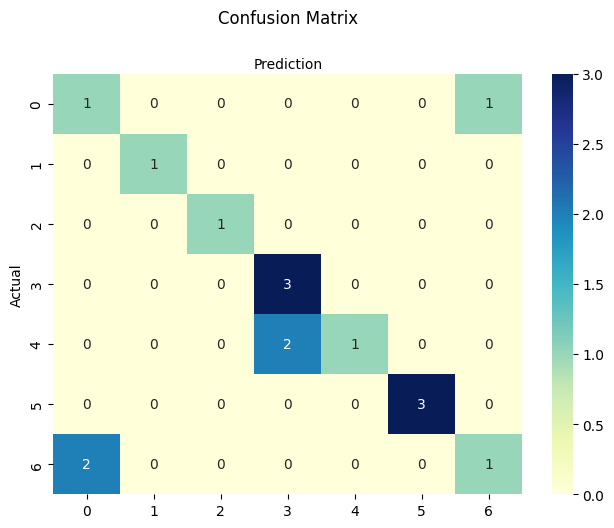

In [ ]:
# plot the convergence per epoch
plot_convergence(loss_train_history, loss_val_history)

# create heatmap for confusion matrix
# code frome example
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

While the first attempt at a ResNet-based architecture does produce a large level of overfitting that is visible during training in the form of diverging losses, the fidelity of the classifier is nevertheless improved dramatically – with a much larger F1 score, precision and sensitivity than the previous example, ResNet’s introduction of skip connections have made the model quicker-fitting than its counterparts. The level of the noise in the training from stochastic gradient descent also disappears as training progresses, hinting the model may be better able to learn as time goes on provided it does not overfit.

### (b) ResNet-10 variations

#### Parameter penalties (weight decay, $\lambda = 0.001$)

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
          'horse', 'ship', 'truck'] # labels map 1:1 to CIFAR10
n_out = 10
model = ResNet10().to(device=device)

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                           shuffle=False)

alpha = 1e-2
optimizer = optim.SGD(model.parameters(), lr=alpha)
n_epochs = 300
loss_fn = nn.CrossEntropyLoss()

# modified training loop with parameter penalties
loss_train_history = np.zeros(n_epochs)
loss_val_history = np.zeros(n_epochs)
for epoch in range(1, n_epochs + 1):
  for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    batch_size = imgs.shape[0]
    h_train = model.forward(imgs)
    loss_train = loss_fn(h_train, labels)
    loss_train_history[epoch-1] = loss_train

    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    loss_train = loss_train + l2_lambda * l2_norm

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

  total = 0
  correct = 0
  with torch.no_grad():
    for imgs, labels in val_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      batch_size = imgs.shape[0]
      h_val = model.forward(imgs)
      loss_val = loss_fn(h_val, labels)
      loss_val_history[epoch-1] = loss_val

      _, labels_val = torch.max(h_val, dim=1)

      confusion = metrics.confusion_matrix(labels.cpu(), labels_val.cpu())
      total += labels.shape[0]
      correct += int((labels == labels_val).sum())
      training_metrics = {'Accuracy': (correct / total),
                          'Precision': metrics.precision_score(labels.cpu(),
                                                               labels_val.cpu(),
                                                               average='macro',
                                                               zero_division=0),
                          'Recall': metrics.recall_score(labels.cpu(),
                                                         labels_val.cpu(),
                                                         average='macro',
                                                         zero_division=0),
                          'F1 Score': metrics.f1_score(labels.cpu(),
                                                       labels_val.cpu(),
                                                       average='macro',
                                                       zero_division=0)}

  print(f'Epoch {epoch}: training loss {loss_train:.4f},',
        f'validation loss {loss_val:.4f}')
  for i in training_metrics:
    print("{}: {}".format(i, training_metrics[i]))
  print()

Epoch 1: training loss 1.6267, validation loss 1.5626
Accuracy: 0.3487
Precision: 0.3333333333333333
Recall: 0.24999999999999997
F1 Score: 0.22916666666666666

Epoch 2: training loss 1.6085, validation loss 1.6588
Accuracy: 0.3831
Precision: 0.4285714285714286
Recall: 0.41666666666666663
F1 Score: 0.3875

Epoch 3: training loss 1.3997, validation loss 0.9846
Accuracy: 0.4694
Precision: 0.6428571428571429
Recall: 0.6428571428571427
F1 Score: 0.6272108843537415

Epoch 4: training loss 1.0159, validation loss 1.1358
Accuracy: 0.6031
Precision: 0.4259259259259259
Recall: 0.4444444444444444
F1 Score: 0.4338624338624338

Epoch 5: training loss 1.1988, validation loss 0.9732
Accuracy: 0.5719
Precision: 0.5
Recall: 0.4629629629629629
F1 Score: 0.47777777777777775

Epoch 6: training loss 1.3501, validation loss 1.1271
Accuracy: 0.5943
Precision: 0.31481481481481477
Recall: 0.33333333333333326
F1 Score: 0.32275132275132273

Epoch 7: training loss 1.3261, validation loss 1.0158
Accuracy: 0.6187
P

Training loss history: [1.57876861 1.55703568 1.34477425 0.95770407 1.13736188 1.28547192
 1.25836396 0.87276155 0.70670152 0.67730868 1.39648604 0.82603598
 0.68470097 0.77644789 0.88210589 0.68771958 0.75189614 0.93264449
 0.55700493 0.4611308  0.85247481 0.5606516  0.45912245 0.56907666
 0.47036192 0.8356632  0.19282371 0.40878057 0.24612993 0.39000005
 0.56888485 0.383064   0.62830257 0.53964806 0.23829991 0.13505612
 0.27579853 0.26277494 0.40629703 0.32573199 0.12431538 0.07354146
 0.30541745 0.14876612 0.50765228 0.16752434 0.26566046 0.24871862
 0.16513962 0.19430806 0.15543711 0.1726487  0.19946854 0.19904746
 0.27860293 0.42766467 0.08039949 0.07761908 0.06687114 0.03915662
 0.08551831 0.11738689 0.03351486 0.04445646 0.03045153 0.03594515
 0.05154278 0.01548085 0.0166389  0.0263748  0.02005652 0.03450853
 0.02772005 0.01873475 0.02950423 0.97241205 0.50967717 0.5093286
 0.64046478 0.23107366 0.10409097 0.27670491 0.15701696 0.2217757
 0.21172133 0.07194007 0.48917091 0.41859

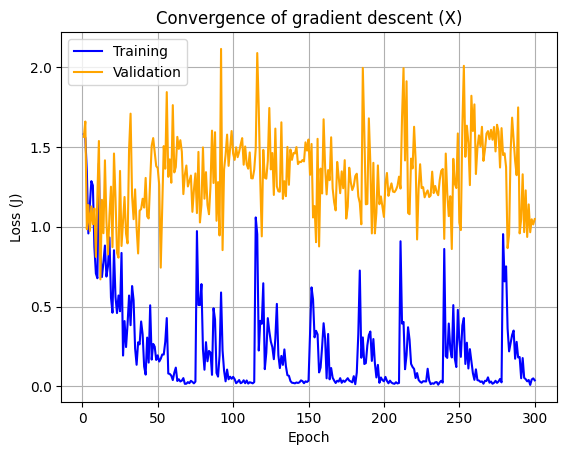

Text(50.722222222222214, 0.5, 'Actual')

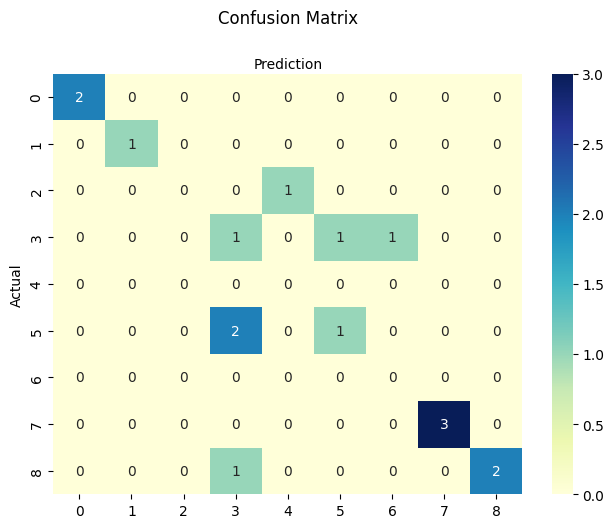

In [ ]:
# plot the convergence per epoch
plot_convergence(loss_train_history, loss_val_history)

# create heatmap for confusion matrix
# code frome example
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

Adding parameter penalties produces a network which, while achieving an apparently better generalization initially, quickly begins to overfit and oscillate. The final result after 300 epochs of training does not perform well compared to the basic ResNet-10, which hints that, while this level of parameter penalty adequately addresses overfeeding, the level may be too high to get a high-quality fit.

#### Dropout

In [ ]:
# ResNet10 with a dropout before the ResBlocks
class ResNet10Dropout(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.conv1_dropout = nn.Dropout2d(p=0.3)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)
    self.resblocks = nn.Sequential(
        *(10 * [ResBlockBasic(n_chans=n_chans1)])
    )
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * n_chans1, 64)
    self.act2 = nn.Tanh()
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.resblocks(out)
    out = self.pool2(out)
    out = out.view(-1, 8 * 8 * self.n_chans1)
    out = self.act2(self.fc1(out))
    out = self.fc2(out)
    return out

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
          'horse', 'ship', 'truck'] # labels map 1:1 to CIFAR10
n_out = 10
model = ResNet10Dropout().to(device=device)

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                           shuffle=False)

alpha = 1e-2
optimizer = optim.SGD(model.parameters(), lr=alpha)
n_epochs = 300
loss_fn = nn.CrossEntropyLoss()

loss_train_history = np.zeros(n_epochs)
loss_val_history = np.zeros(n_epochs)
for epoch in range(1, n_epochs + 1):
  for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    batch_size = imgs.shape[0]
    h_train = model.forward(imgs)
    loss_train = loss_fn(h_train, labels)
    loss_train_history[epoch-1] = loss_train

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

  total = 0
  correct = 0
  with torch.no_grad():
    for imgs, labels in val_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      batch_size = imgs.shape[0]
      h_val = model.forward(imgs)
      loss_val = loss_fn(h_val, labels)
      loss_val_history[epoch-1] = loss_val

      _, labels_val = torch.max(h_val, dim=1)

      confusion = metrics.confusion_matrix(labels.cpu(), labels_val.cpu())
      total += labels.shape[0]
      correct += int((labels == labels_val).sum())
      training_metrics = {'Accuracy': (correct / total),
                          'Precision': metrics.precision_score(labels.cpu(),
                                                               labels_val.cpu(),
                                                               average='macro',
                                                               zero_division=0),
                          'Recall': metrics.recall_score(labels.cpu(),
                                                         labels_val.cpu(),
                                                         average='macro',
                                                         zero_division=0),
                          'F1 Score': metrics.f1_score(labels.cpu(),
                                                       labels_val.cpu(),
                                                       average='macro',
                                                       zero_division=0)}

  print(f'Epoch {epoch}: training loss {loss_train:.4f},',
        f'validation loss {loss_val:.4f}')
  for i in training_metrics:
    print("{}: {}".format(i, training_metrics[i]))
  print()

Epoch 1: training loss 2.3074, validation loss 2.3412
Accuracy: 0.1
Precision: 0.0
Recall: 0.0
F1 Score: 0.0

Epoch 2: training loss 1.6754, validation loss 1.8939
Accuracy: 0.3485
Precision: 0.037037037037037035
Recall: 0.1111111111111111
F1 Score: 0.05555555555555555

Epoch 3: training loss 1.5119, validation loss 1.7276
Accuracy: 0.5037
Precision: 0.3333333333333333
Recall: 0.18518518518518517
F1 Score: 0.21904761904761905

Epoch 4: training loss 1.0947, validation loss 1.4368
Accuracy: 0.5093
Precision: 0.4722222222222222
Recall: 0.35185185185185186
F1 Score: 0.3804232804232804

Epoch 5: training loss 1.5108, validation loss 0.9671
Accuracy: 0.5122
Precision: 0.7857142857142858
Recall: 0.7380952380952381
F1 Score: 0.7482993197278912

Epoch 6: training loss 1.3605, validation loss 0.9846
Accuracy: 0.5896
Precision: 0.5166666666666667
Recall: 0.4166666666666667
F1 Score: 0.4404761904761905

Epoch 7: training loss 1.0890, validation loss 1.0284
Accuracy: 0.5248
Precision: 0.5708333333

Training loss history: [2.30744529e+00 1.67535305e+00 1.51192975e+00 1.09465492e+00
 1.51079416e+00 1.36047804e+00 1.08897328e+00 8.88904631e-01
 4.25851017e-01 1.27806771e+00 5.09019017e-01 5.91208279e-01
 6.52006149e-01 6.83896065e-01 6.37753487e-01 3.40326130e-01
 1.09414876e+00 3.20614755e-01 7.49369085e-01 5.83710015e-01
 4.94259030e-01 2.22507313e-01 2.52862394e-01 5.20478606e-01
 5.34416318e-01 4.38484907e-01 3.30644697e-01 2.58875549e-01
 1.97786510e-01 6.06068552e-01 2.11794242e-01 1.29465327e-01
 2.67379045e-01 1.69683725e-01 3.60833794e-01 2.37756103e-01
 1.01938792e-01 1.71064585e-01 1.15748510e-01 1.97489962e-01
 2.53826469e-01 2.32922450e-01 1.92728788e-01 1.36766702e-01
 1.07106969e-01 1.03770338e-01 5.60280532e-02 1.35488948e-02
 3.11560094e-01 1.68110281e-02 1.02372617e-01 2.03354359e-02
 1.54384747e-02 1.16678998e-02 1.04387943e-02 1.55577017e-02
 7.27860071e-03 1.11863390e-02 2.32556723e-02 7.54006952e-03
 8.60716403e-03 9.57779214e-03 1.32640246e-02 4.75329012e-02
 

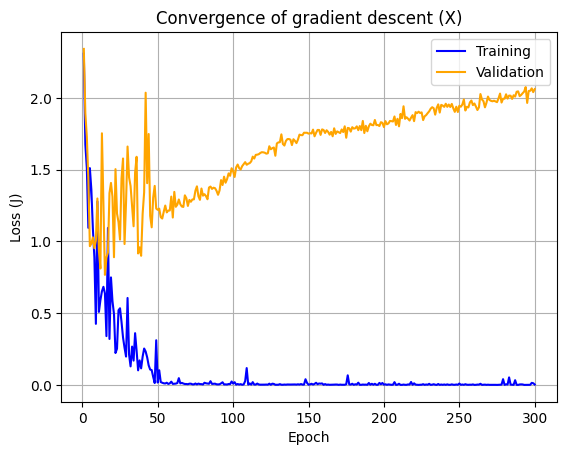

Text(50.722222222222214, 0.5, 'Actual')

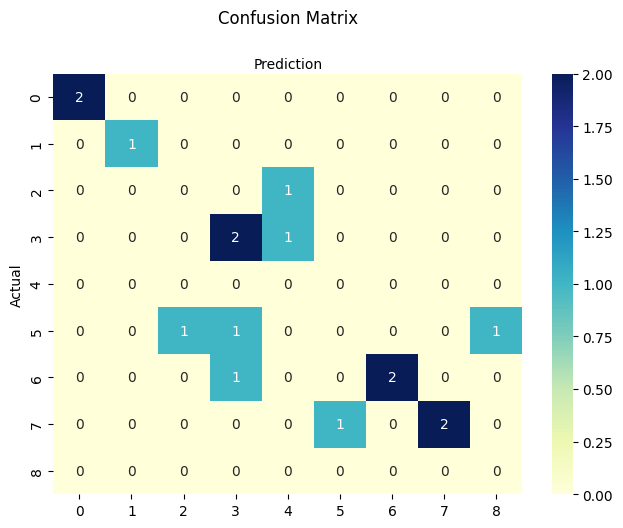

In [ ]:
# plot the convergence per epoch
plot_convergence(loss_train_history, loss_val_history)

# create heatmap for confusion matrix
# code frome example
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

While it does dramatically decrease the noise in training, introducing a dropout layer with p=0.3 to this network before the cascade of ResBlocks further degrades generalization performance for this example. This likely is a result of extreme overfitting, since, similar to the vanilla ResNet-10 example, the training loss in this example converged to a value of 0.0031 after 300 epochs of training and did not oscillate. Meanwhile, the accuracy reflects an improvement on the vanilla example even as generalization is impaired, indicating how dropout makes the model more certain in what it does know while compromising the impact of new data as training epochs increase.

#### Batch normalization

In [ ]:
# enhanced ResNet block from lecture/DLWPT with batch normalization
class ResBlockNorm(nn.Module):
  def __init__(self, n_chan):
    super(ResBlockNorm, self).__init__()
    self.conv = nn.Conv2d(n_chan, n_chan, kernel_size=3, padding=1,
                          bias=False)
    self.batch_norm = nn.BatchNorm2d(num_features=n_chan)
    nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
    nn.init.constant_(self.batch_norm.weight, 0.5)
    nn.init.zeros_(self.batch_norm.bias)

  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x

In [ ]:
# ResNet10 with batch normalization
class ResNet10Norm(nn.Module):
  def __init__(self, n_chans1=32):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.act1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(2)
    self.resblocks = nn.Sequential(
        *(10 * [ResBlockNorm(n_chan=n_chans1)])
    )
    self.pool2 = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(8 * 8 * n_chans1, 64)
    self.act2 = nn.Tanh()
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    out = self.pool1(self.act1(self.conv1(x)))
    out = self.resblocks(out)
    out = self.pool2(out)
    out = out.view(-1, 8 * 8 * self.n_chans1)
    out = self.act2(self.fc1(out))
    out = self.fc2(out)
    return out

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
          'horse', 'ship', 'truck'] # labels map 1:1 to CIFAR10
n_out = 10
model = ResNet10Norm().to(device=device)

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                           shuffle=False)

alpha = 1e-2
optimizer = optim.SGD(model.parameters(), lr=alpha)
n_epochs = 300
loss_fn = nn.CrossEntropyLoss()

loss_train_history = np.zeros(n_epochs)
loss_val_history = np.zeros(n_epochs)
for epoch in range(1, n_epochs + 1):
  for imgs, labels in train_loader:
    imgs = imgs.to(device=device)
    labels = labels.to(device=device)
    batch_size = imgs.shape[0]
    h_train = model.forward(imgs)
    loss_train = loss_fn(h_train, labels)
    loss_train_history[epoch-1] = loss_train

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

  total = 0
  correct = 0
  with torch.no_grad():
    for imgs, labels in val_loader:
      imgs = imgs.to(device=device)
      labels = labels.to(device=device)
      batch_size = imgs.shape[0]
      h_val = model.forward(imgs)
      loss_val = loss_fn(h_val, labels)
      loss_val_history[epoch-1] = loss_val

      _, labels_val = torch.max(h_val, dim=1)

      confusion = metrics.confusion_matrix(labels.cpu(), labels_val.cpu())
      total += labels.shape[0]
      correct += int((labels == labels_val).sum())
      training_metrics = {'Accuracy': (correct / total),
                          'Precision': metrics.precision_score(labels.cpu(),
                                                               labels_val.cpu(),
                                                               average='macro',
                                                               zero_division=0),
                          'Recall': metrics.recall_score(labels.cpu(),
                                                         labels_val.cpu(),
                                                         average='macro',
                                                         zero_division=0),
                          'F1 Score': metrics.f1_score(labels.cpu(),
                                                       labels_val.cpu(),
                                                       average='macro',
                                                       zero_division=0)}

  print(f'Epoch {epoch}: training loss {loss_train:.4f},',
        f'validation loss {loss_val:.4f}')
  for i in training_metrics:
    print("{}: {}".format(i, training_metrics[i]))
  print()

Epoch 1: training loss 1.4015, validation loss 1.4640
Accuracy: 0.4767
Precision: 0.2333333333333333
Recall: 0.2333333333333333
F1 Score: 0.21000000000000002

Epoch 2: training loss 1.4283, validation loss 1.2825
Accuracy: 0.5133
Precision: 0.3333333333333333
Recall: 0.3
F1 Score: 0.31333333333333335

Epoch 3: training loss 0.8826, validation loss 1.2000
Accuracy: 0.5764
Precision: 0.34259259259259256
Recall: 0.3333333333333333
F1 Score: 0.29523809523809524

Epoch 4: training loss 1.5849, validation loss 1.3078
Accuracy: 0.5571
Precision: 0.4270833333333333
Recall: 0.3958333333333333
F1 Score: 0.39880952380952384

Epoch 5: training loss 0.9179, validation loss 1.3017
Accuracy: 0.5947
Precision: 0.5166666666666667
Recall: 0.39999999999999997
F1 Score: 0.4238095238095238

Epoch 6: training loss 0.8071, validation loss 1.2321
Accuracy: 0.6265
Precision: 0.36666666666666664
Recall: 0.29999999999999993
F1 Score: 0.3138095238095238

Epoch 7: training loss 0.9574, validation loss 0.9315
Accur

Training loss history: [1.40152597 1.42834377 0.8825947  1.58489943 0.91789424 0.80713999
 0.95743978 0.76306438 0.70232046 0.55734789 0.50995773 0.33107102
 1.2446878  0.63594657 1.00755239 0.58743596 0.47424108 0.50171757
 0.30153283 0.5949806  0.75507915 0.93809855 0.79811496 0.19625026
 0.30458447 0.36624855 0.59687173 0.55616939 0.42954516 0.48906338
 0.85150218 0.35653037 0.31225139 0.32865751 0.60376143 0.20518878
 0.30617982 0.4342674  0.73170334 0.23503515 0.5219658  0.2039981
 0.10352787 0.19006042 0.36926961 0.06681648 0.0429183  0.32690942
 0.37911069 0.17771991 0.31567809 0.17716259 0.5896405  0.16753376
 0.19949621 0.09889059 0.15495899 0.04398385 0.07991871 0.2663607
 0.15515611 0.15846476 0.05434466 0.05954666 0.09712861 0.0528027
 0.05647783 0.25252843 0.08492103 0.03300964 0.07995322 0.03524698
 0.02647116 0.06887144 0.08719911 0.15989402 0.03241724 0.37532067
 0.02798154 0.04462615 0.03496443 0.02321238 0.03336786 0.05444507
 0.04423422 0.00782051 0.01919202 0.005120

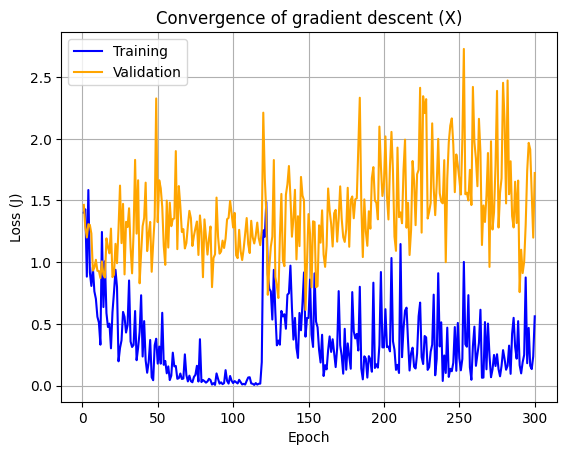

Text(50.722222222222214, 0.5, 'Actual')

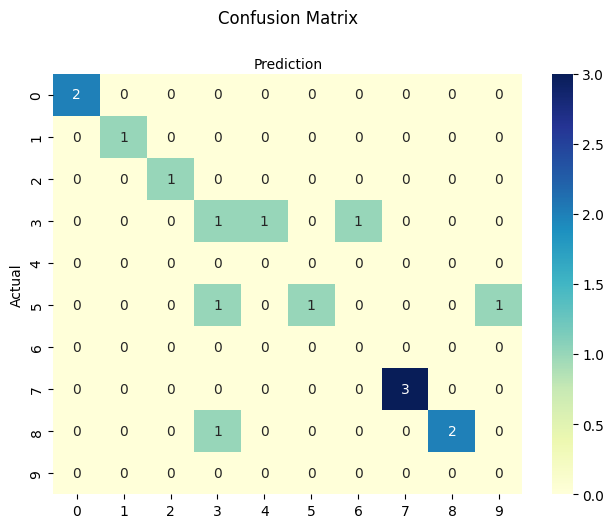

In [ ]:
# plot the convergence per epoch
plot_convergence(loss_train_history, loss_val_history)

# create heatmap for confusion matrix
# code frome example
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

Introduction of batch normalization to the ResBlocks of the ResNet section creates an interesting behavior – this example converges to a very low level of training loss before it “bounces” off the bottom and becomes noisy again. This variation has trouble generalizing in the current configuration and also does not provide a good fit, however this technique appears to show promise if the overfitting issue that occurs early on in training can be addressed.